In [1]:
# Uncommente the following line to install the necessary dependencies
# !pip install -r requirements.txt

Le normalization permet de normaliser le signal audio en faisant en sorte que la valeur la plus grande dans le signal soit égale à 1, ce qui peut aider à éliminer les variations dans l'amplitude du signal audio qui peuvent être causées par des différences de distance ou d'enregistrement de micro entre les différentes sources audio. Cela peut être utile pour une analyse et une comparaison plus cohérentes des signaux audio. En utilisant la normalisation dans ce cas, nous nous assurons que la différence de valeur absolue maximale dans le signal audio soit de 1 pour tous les signaux audio, ce qui peut faciliter la comparaison entre les différents signaux audio.

FAIRE UN TEST AVEC PEU DE PARAMS
AFFICHER PLUSIEURS

Le choix de la méthode de normalisation dépend des données et du modèle utilisé. Cependant, la normalisation L2 ou la normalisation z-score peuvent être utilisées pour préparer les données pour une classification à 10 classes. La normalisation L2 consiste à normaliser les données pour qu'elles soient distribuées sur une sphere de rayon 1. La normalisation z-score consiste à normaliser les données en les centrant autour de la moyenne et en les réduisant à une échelle standard. Dans les deux cas, la normalisation permet d'éviter que les valeurs extrêmes d'une caractéristique ne dominent la distance de mesure utilisée par le modèle.

# Introduction

In this notebook, we will explore the sound data of the [UrbanSound8k](https://urbansounddataset.weebly.com/urbansound8k.html). (see [README](./data/UrbanSound8K_README.txt) for more details).

We will use exploratory data analysis (EDA) techniques to understand trends and patterns in the data. 

Then, we will create a prediction model in the form of a neural network to solve a sound classification problem with 10 classes. 

Finally, we will evaluate the performance of the model and make a conclusion on the results obtained. 

## Setup

In [94]:
# Reload 'utils.py'
import utils
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\grond\\Documents\\projects\\sound_project\\utils.py'>

In [95]:
# Load libraries
import os

from tqdm import tqdm

import scipy.io.wavfile as wavfile

import IPython.display as ipd

import librosa
import librosa.display

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras

from scikeras.wrappers import KerasClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from utils import set_default, try_gpu, load_data, display_distributions, display_distributions_w_labels, display_leaning_curves, display_best_hyperparameters, normalize_w_librosa, generate_data, evaluate_model, librosa_get_examples

In [96]:
# Set style
%matplotlib inline
set_default()

In [97]:
# Use GPU or CPU for tensorflow:
try_gpu()

No GPU available


False

In [81]:
# Define the file paths
ROOT_PATH = "./data/"
AUDIO_PATH = os.path.join(ROOT_PATH, "audio/fold")
CREATION_PATH = os.path.join(ROOT_PATH, "creation")
METADATA_PATH = os.path.join(ROOT_PATH, "metadata/UrbanSound8k.csv")
FEATURES_PATH = os.path.join(CREATION_PATH, "features.csv")
MELSPECTROGRAM_FEATURES_PATH = os.path.join(CREATION_PATH, "melspectrogram_features.csv")
AUDIO_DATA_PATH = os.path.join(CREATION_PATH, "audio_data.csv")
BEST_MODEL_PATH = "sound_project_model"

In [6]:
# Define some constants
WAVFILE = 'wavfile'
LIBROSA = 'librosa'

## Load metadata

In [7]:
# Load metadata from UrbanSound8k.csv file
metadata = load_data(METADATA_PATH)
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [8]:
# We find well the information indicated in the associated readme
metadata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [9]:
metadata.describe()

fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000

In [10]:
# For simplicity, we add the complete file path of each audio file to the 'signal_path' column
metadata['signal_path'] = AUDIO_PATH + metadata['fold'].astype(str) + '/' + metadata['slice_file_name']
metadata.head(10)

slice_file_name    fsID      start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032   0.000000   0.317551         1     5        3   
1  100263-2-0-117.wav  100263  58.500000  62.500000         1     5        2   
2  100263-2-0-121.wav  100263  60.500000  64.500000         1     5        2   
3  100263-2-0-126.wav  100263  63.000000  67.000000         1     5        2   
4  100263-2-0-137.wav  100263  68.500000  72.500000         1     5        2   
5  100263-2-0-143.wav  100263  71.500000  75.500000         1     5        2   
6  100263-2-0-161.wav  100263  80.500000  84.500000         1     5        2   
7    100263-2-0-3.wav  100263   1.500000   5.500000         1     5        2   
8   100263-2-0-36.wav  100263  18.000000  22.000000         1     5        2   
9    100648-1-0-0.wav  100648   4.823402   5.471927         2    10        1   

              class                            signal_path  
0          dog_bark    ./data/audio/fold5/100032-3-0-0.wav  
1  children_playing  ./data/audio/fold5/100263-2-0-117.wav  
2  children_playing  ./data/audio/fold5/100263-2-0-121.wav  
3  children_playing  ./data/audio/fold5/100263-2-0-126.wav  
4  children_playing  ./data/audio/fold5/100263-2-0-137.wav  
5  children_playing  ./data/audio/fold5/100263-2-0-143.wav  
6  children_playing  ./data/audio/fold5/100263-2-0-161.wav  
7  children_playing    ./data/audio/fold5/100263-2-0-3.wav  
8  children_playing   ./data/audio/fold5/100263-2-0-36.wav  
9          car_horn   ./data/audio/fold10/100648-1-0-0.wav

## Exploratory Data Analysis

######
First, we will use the *.wav* format to analyze our sounds with *scipy*.The *.wav* format is an uncompressed file format, which means that it does not reduce the file size in exchange for a loss of audio quality. A .wav file contains information about the audio data, such as sample rate, bits per sample, and number of channels, as well as the raw audio data.

In [11]:
# First, we will explore one audio
TEST_INDEX = 0
music_test = metadata['signal_path'][TEST_INDEX]
#music_test  ='./data/audio/fold1/101415-3-0-2.wav'

In [12]:
test_wav_sr, test_wav_signal = wavfile.read(music_test)

In [13]:
# Listen to the audio signal
ipd.Audio(music_test)

In [14]:
class_name = metadata.at[TEST_INDEX, 'class']
print(f'Class name: {class_name}')

Class name: dog_bark


In [15]:
def display_audio_signal(filename, librarie = WAVFILE):
    if librarie == WAVFILE:
        # Extract information from the WAV file
        sampling_rate, signal = wavfile.read(filename)
    elif librarie == LIBROSA:
        signal, sampling_rate = librosa.load(filename)
    n_samples = signal.shape[0]
    n_channels = signal.shape[1] if signal.ndim == 2 else 1
    
    T = signal.size / sampling_rate # the duration of the signal

    # Print informations
    print(
        f'The signal is {T:.1f}s long.',
        f'The sampling rate is {sampling_rate * 1e-3} kHz, with {n_samples} samples.', # the frequency
        f'There is {n_channels} audio channel(s).',
        sep='\n')

    # Plot the audio signal
    time = np.linspace(0., n_samples/sampling_rate, n_samples)
    if librarie == WAVFILE:
        plt.plot(time, signal[:, 0], label="Left channel")
        if n_channels == 2:
            plt.plot(time, signal[:, 1], label="Right channel")
        plt.legend()
    elif librarie == LIBROSA:
        plt.plot(time, signal)
    
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

The signal is 0.6s long.
The sampling rate is 44.1 kHz, with 14004 samples.
There is 2 audio channel(s).


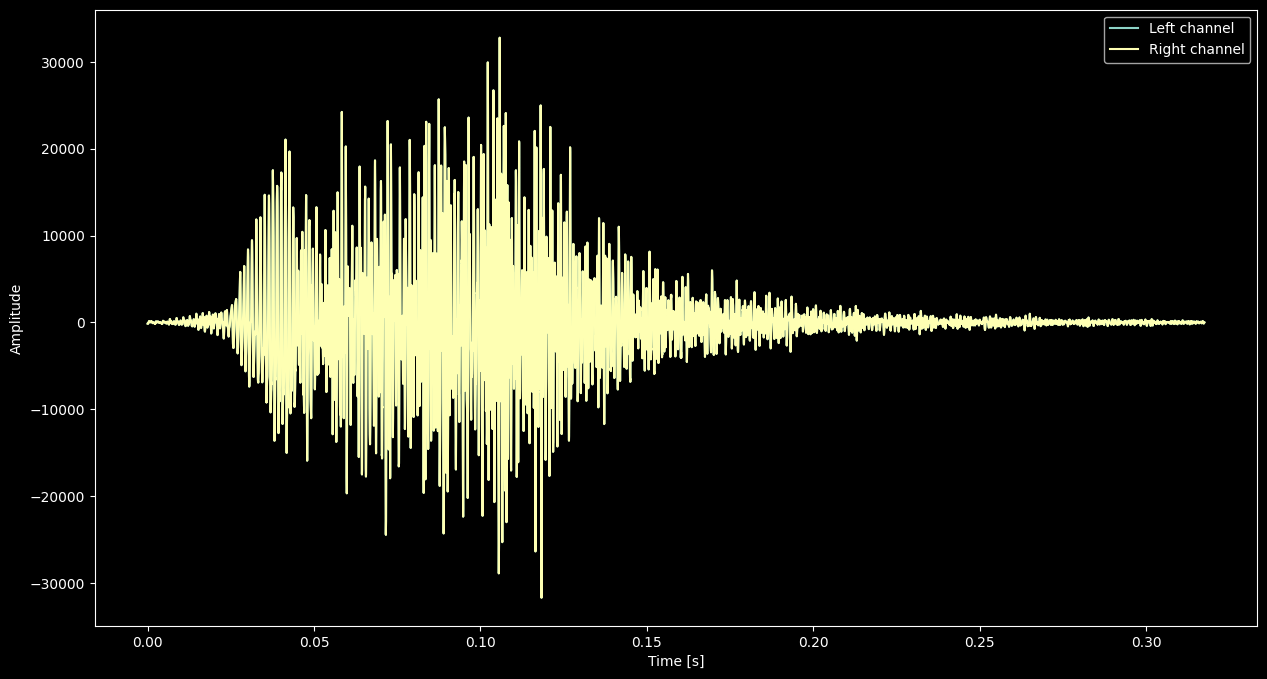

In [16]:
display_audio_signal(music_test)

We can create a dataframe with all this informations

In [17]:
def generate_audio_data_dataframe():
    data = []
    for index_num, row in tqdm(metadata.iterrows()):
        # Extract information from the metadata
        fsID = row['fsID']
        file_name = row["signal_path"]
        classID = row['classID']
        class_name = row['class']
        try:
            # Extract information from the WAV file
            sampling_rate, signal = wavfile.read(row['signal_path'])
            n_samples = signal.shape[0]
            n_channels = signal.shape[1] if signal.ndim == 2 else 1
            T = signal.size / sampling_rate # the duration of the signal
            # In the line below we change format of some data to get:
            # -sampling_rate in kHz
            # -duration in s with 1 decimal
            data.append([fsID, signal, sampling_rate*1e-3, n_samples, n_channels, round(T, 1), classID, class_name])
        except ValueError:
            print(f"The {row['fsID']} file does not have a supported format.")
    df = pd.DataFrame(data, columns=['fsID', 'signal', 'sampling_rate', 'n_samples', 'n_channels', 'duration', 'classID', 'class'])
    df.to_pickle(AUDIO_DATA_PATH)

In [18]:
# Uncommente the following line to generate audio data dataframe 
# generate_audio_data_dataframe()

See result of the cell above [here](./data/images/generate_audio_data_dataframe.png)

In [19]:
audio_data = load_data(AUDIO_DATA_PATH, True)
audio_data.head()

fsID                                             signal  sampling_rate  \
0  100032  [[-150, -148], [-160, -157], [-151, -151], [-1...           44.1   
1  100263  [[171, 63], [157, 86], [130, 96], [78, 105], [...           44.1   
2  100263  [[-77, -168], [-58, -159], [-37, -141], [-20, ...           44.1   
3  100263  [[-59, 76], [-39, 40], [-27, 13], [-39, -11], ...           44.1   
4  100263  [[159, -52], [185, -16], [231, 40], [269, 103]...           44.1   

   n_samples  n_channels  duration  classID             class  
0      14004           2       0.6        3          dog_bark  
1     176400           2       8.0        2  children_playing  
2     176400           2       8.0        2  children_playing  
3     176400           2       8.0        2  children_playing  
4     176400           2       8.0        2  children_playing

In [20]:
# We end up with 9 elements less
# We will be able to work on this dataframe which will be representative of all our sounds
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8723 entries, 0 to 8722
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fsID           8723 non-null   int64  
 1   signal         8723 non-null   object 
 2   sampling_rate  8723 non-null   float64
 3   n_samples      8723 non-null   int64  
 4   n_channels     8723 non-null   int64  
 5   duration       8723 non-null   float64
 6   classID        8723 non-null   int64  
 7   class          8723 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.3+ KB


We can now see some distributions 

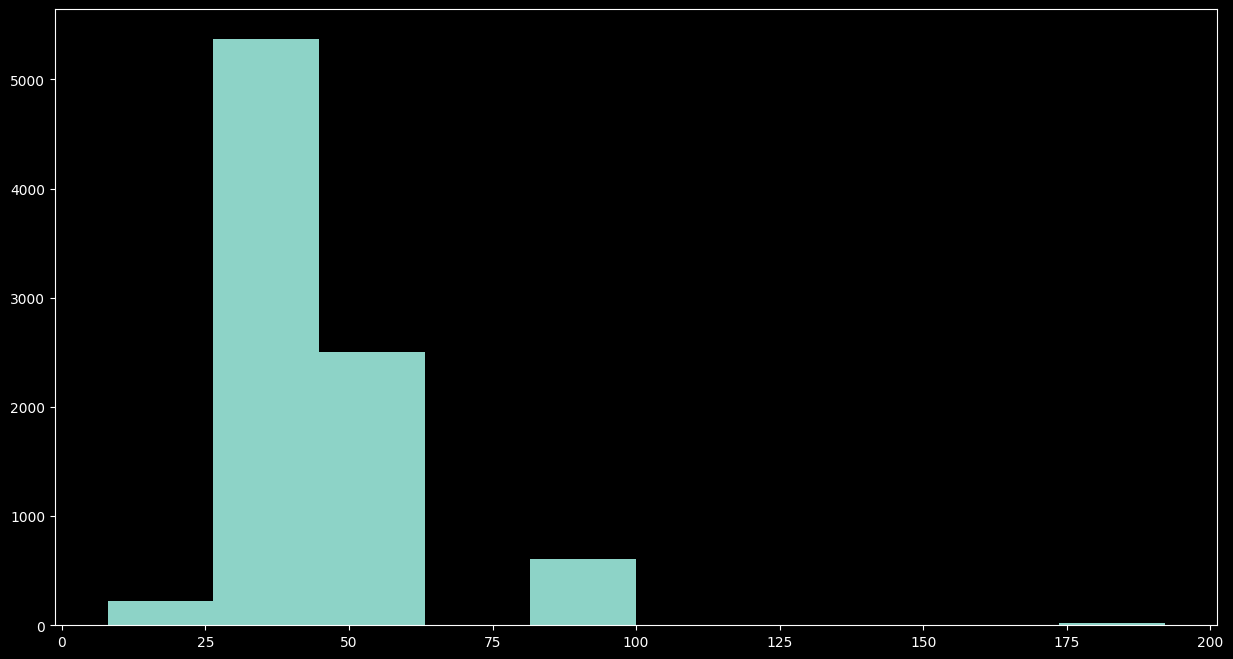

In [21]:
# Distribution of sampling rates
display_distributions(audio_data['sampling_rate'])

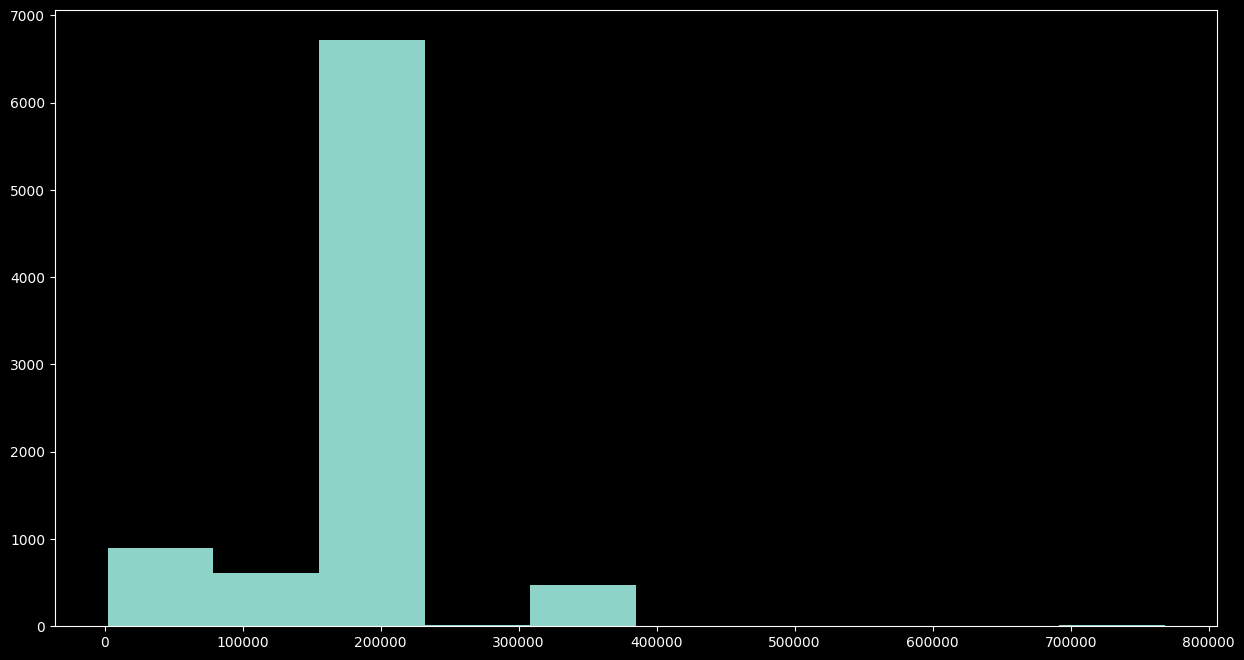

In [22]:
# Distribution of samples
display_distributions(audio_data['n_samples'])

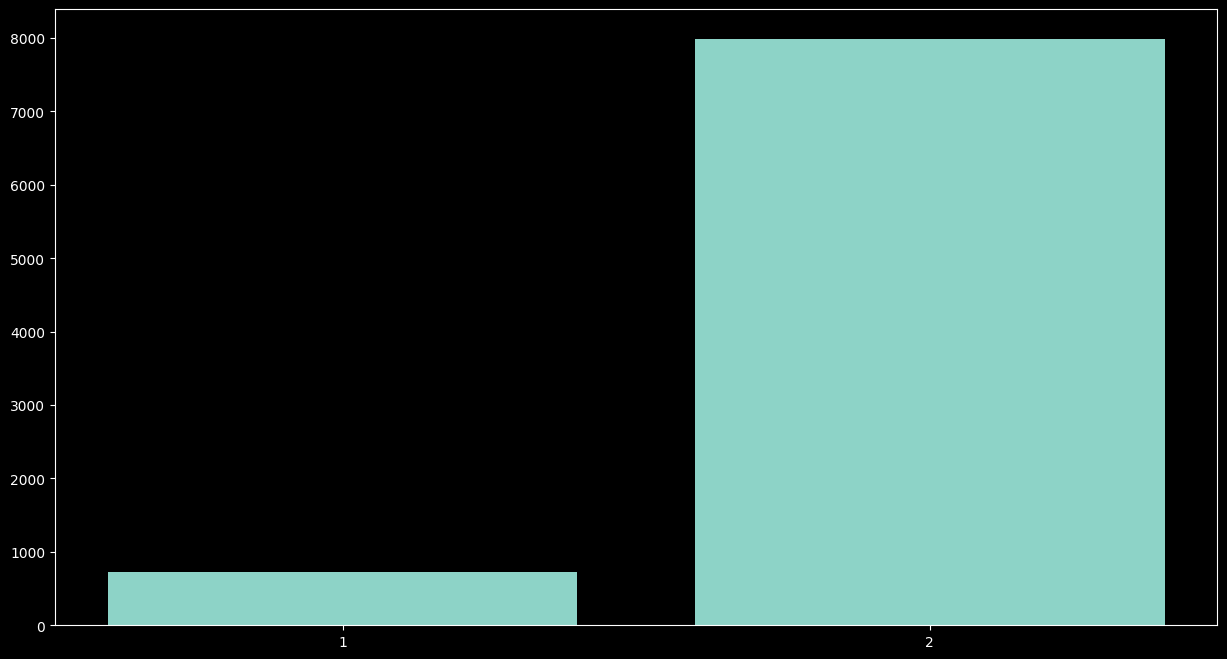

In [23]:
# Distribution of channels
channels_labels, channels_counts = np.unique(audio_data['n_channels'], return_counts=True)
display_distributions_w_labels(channels_labels, channels_counts)

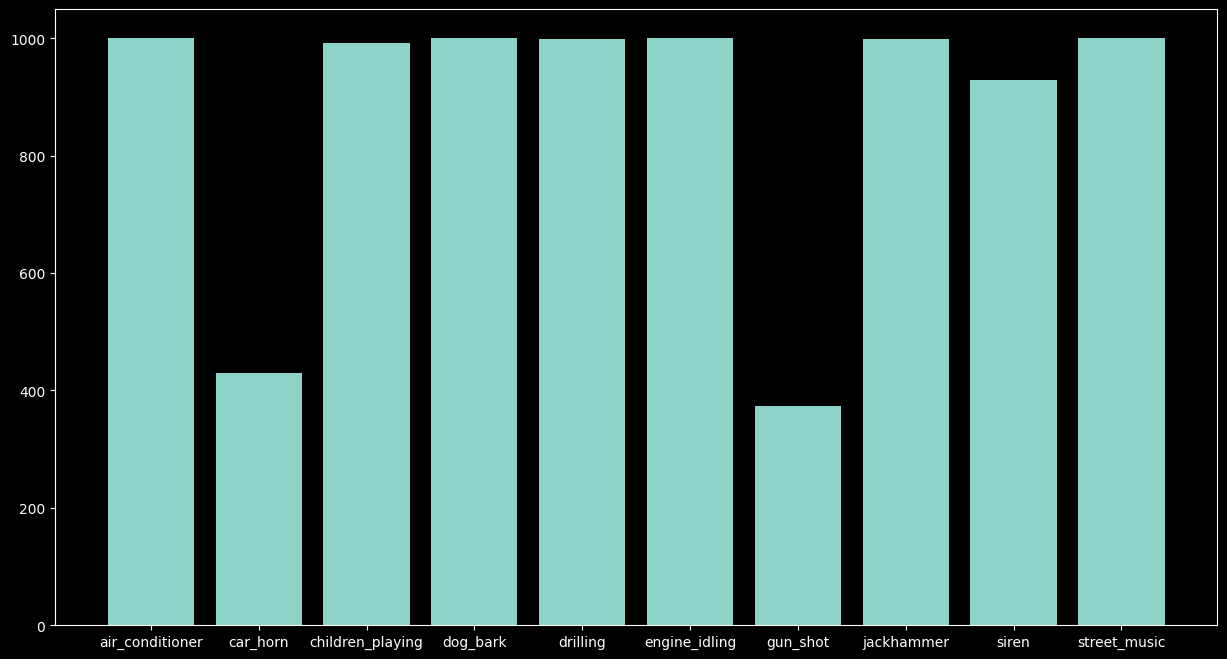

In [24]:
# Distribution of classes
classes_labels, classes_counts = np.unique(audio_data['class'], return_counts=True)
display_distributions_w_labels(classes_labels, classes_counts)

######
Now, we can work with librosa. # explain librosa normalize data

In [25]:
test_librosa_signal, test_librosa_sr = librosa.load(music_test)

In [26]:
X = librosa.stft(test_librosa_signal)

In [27]:
X_dB = librosa.amplitude_to_db(np.abs(X))

The signal is 0.3s long.
The sampling rate is 22.05 kHz, with 7002 samples.
There is 1 audio channel(s).


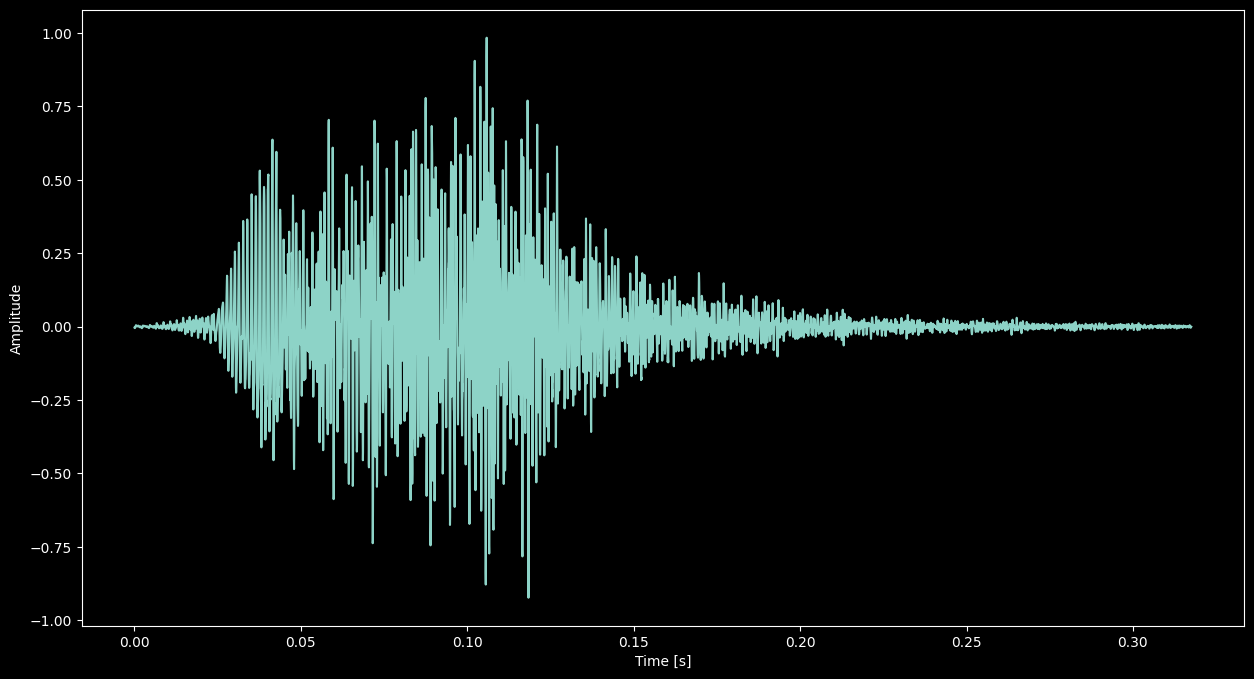

In [28]:
display_audio_signal(music_test, LIBROSA)

In [29]:
class_name = metadata.at[TEST_INDEX, 'class']
print(f'Class name: {class_name}')

Class name: dog_bark


In [30]:
# Relisten to the audio signal
ipd.Audio(music_test)

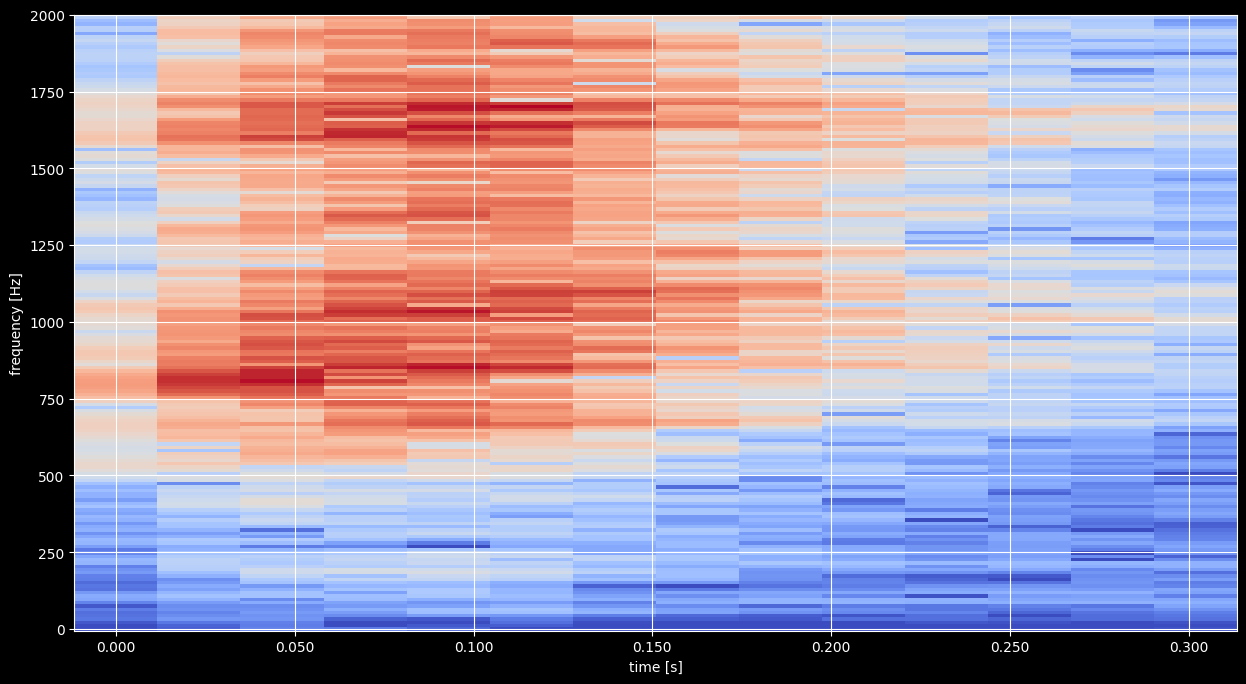

In [31]:
librosa.display.specshow(X_dB, sr=test_librosa_sr, x_axis='time', y_axis='hz')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.ylim(top=2000)
plt.grid(True)

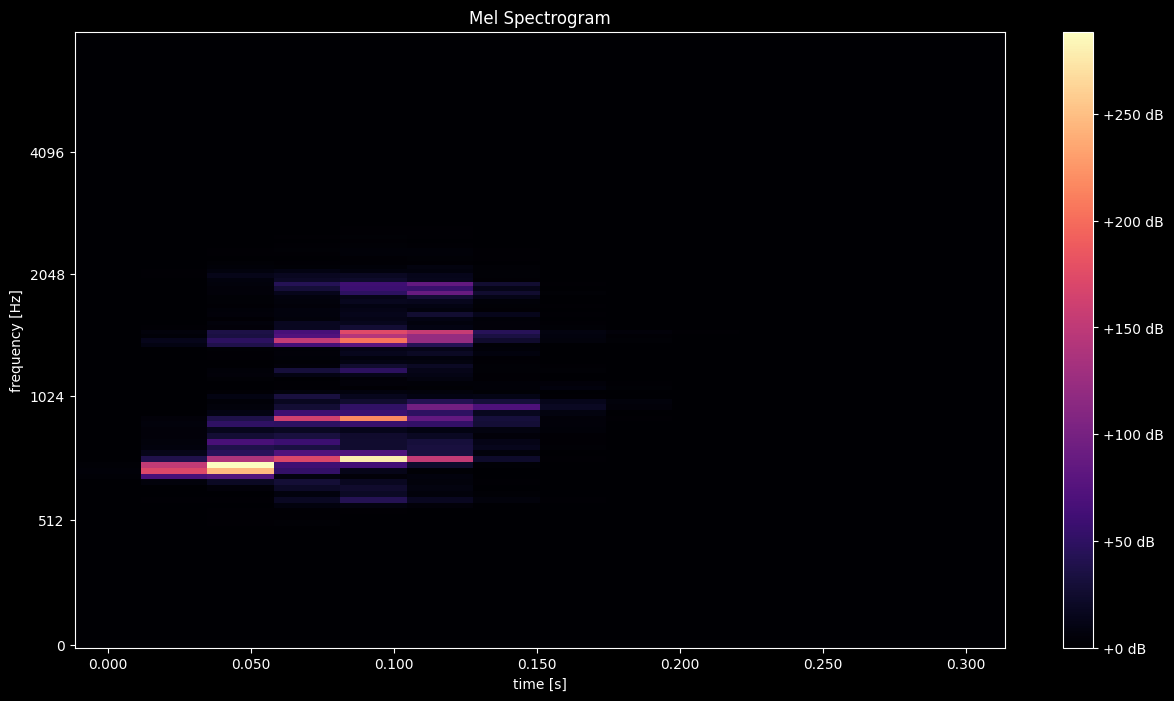

In [32]:
mel_spect = librosa.feature.melspectrogram(y=test_librosa_signal, sr=test_librosa_sr)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

... spectrogram, mel spectrogram, 

In [33]:
# Display list of classes
list(metadata['class'].unique())

['dog_bark',
 'children_playing',
 'car_horn',
 'air_conditioner',
 'street_music',
 'gun_shot',
 'siren',
 'engine_idling',
 'jackhammer',
 'drilling']

<Figure size 1500x800 with 0 Axes>

class name: siren
x[k] has 88200 samples
the sampling rate is 22.05 kHz
x(t) is 4.0s long
the number of channels is 1


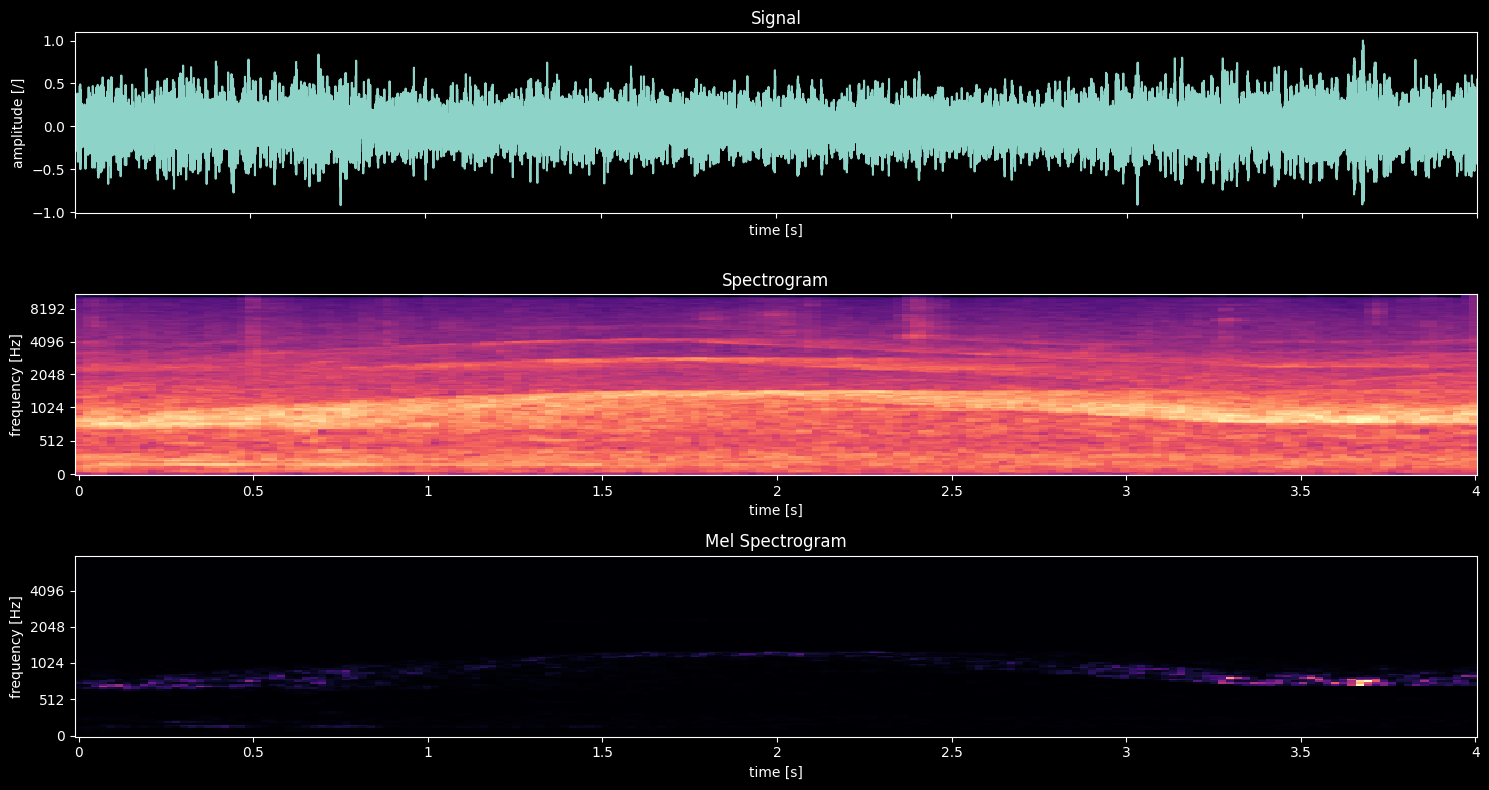

class name: siren
x[k] has 88200 samples
the sampling rate is 22.05 kHz
x(t) is 4.0s long
the number of channels is 1


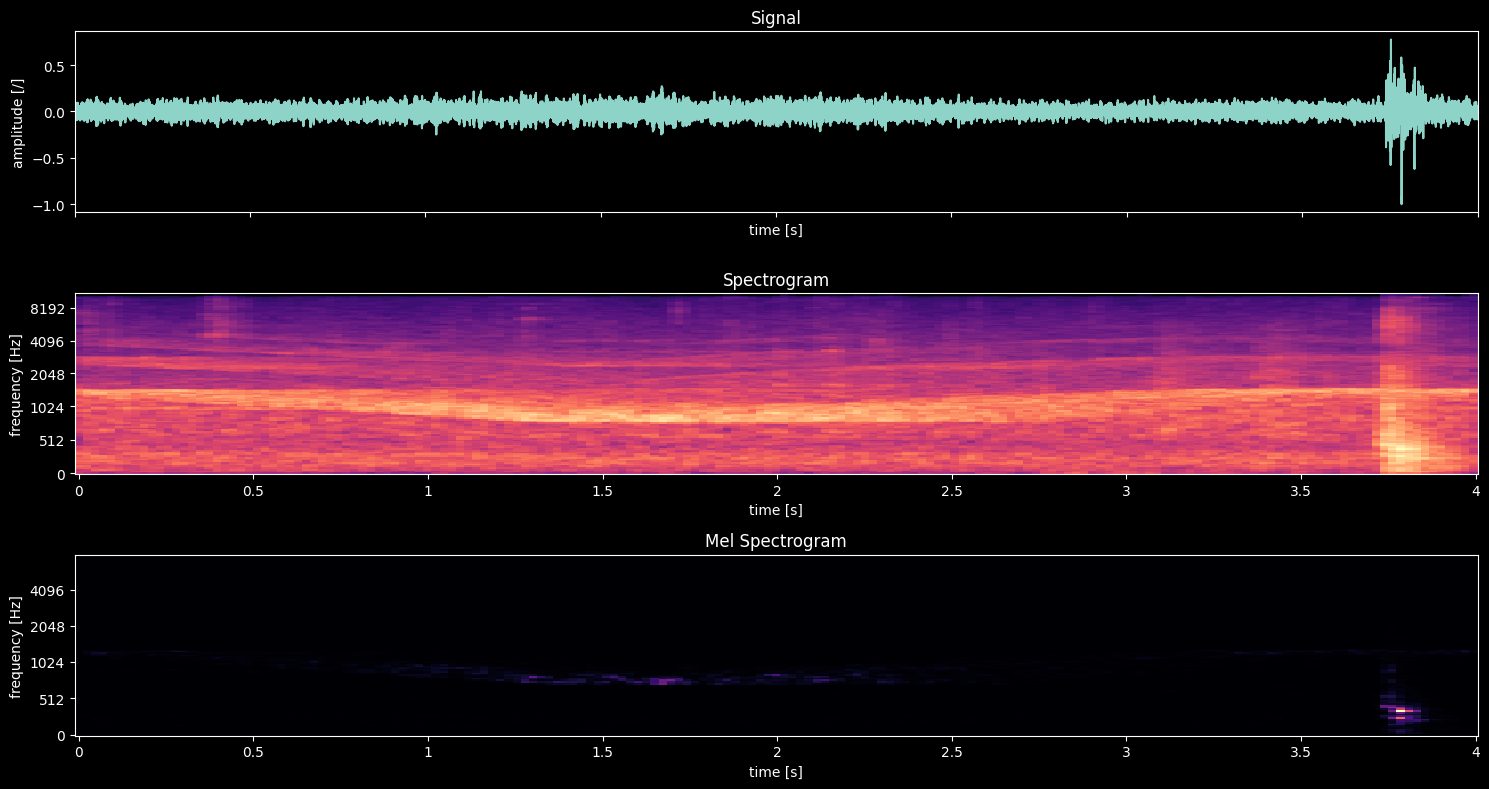

class name: siren
x[k] has 88200 samples
the sampling rate is 22.05 kHz
x(t) is 4.0s long
the number of channels is 1


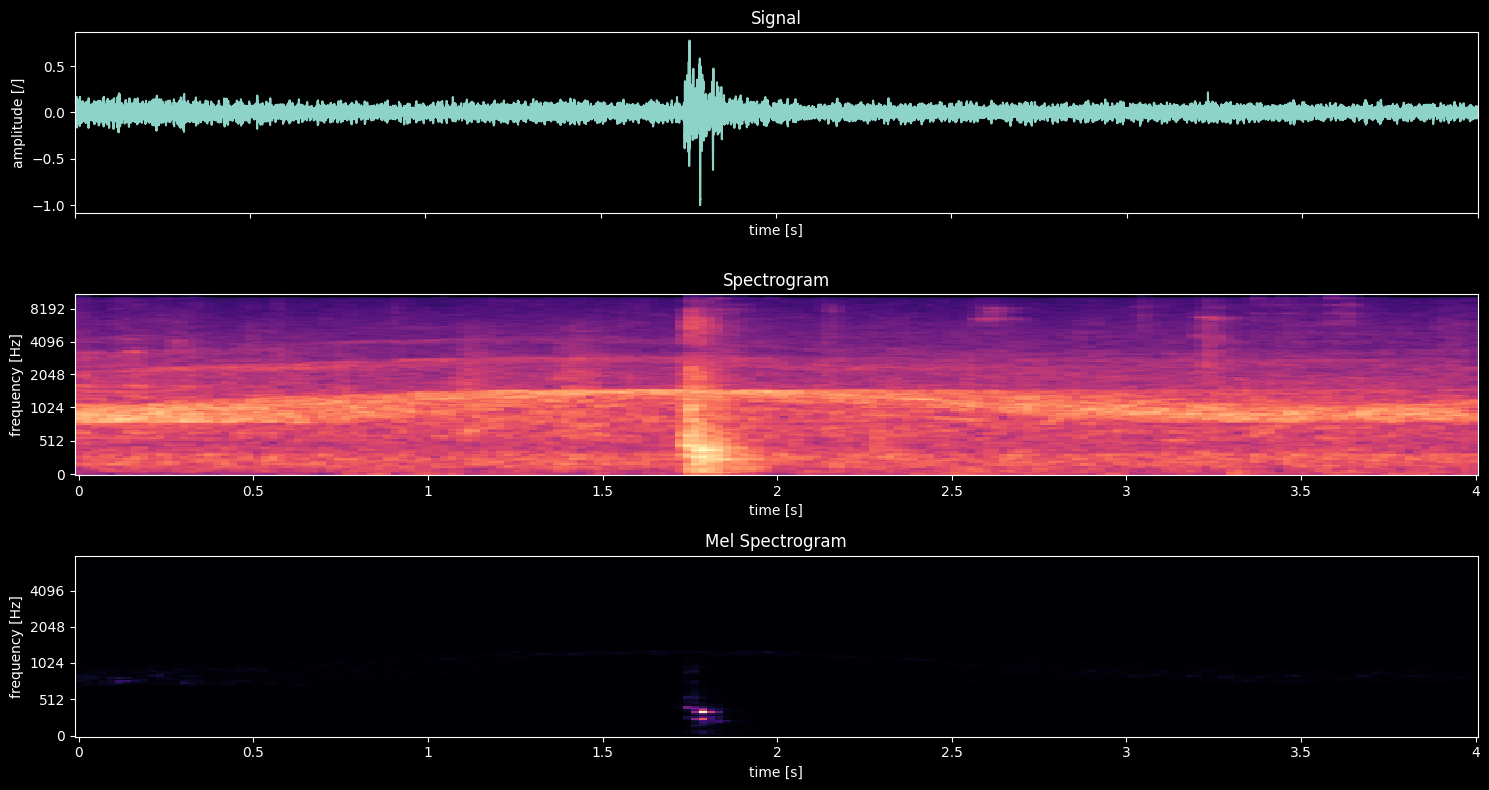

class name: siren
x[k] has 88200 samples
the sampling rate is 22.05 kHz
x(t) is 4.0s long
the number of channels is 1


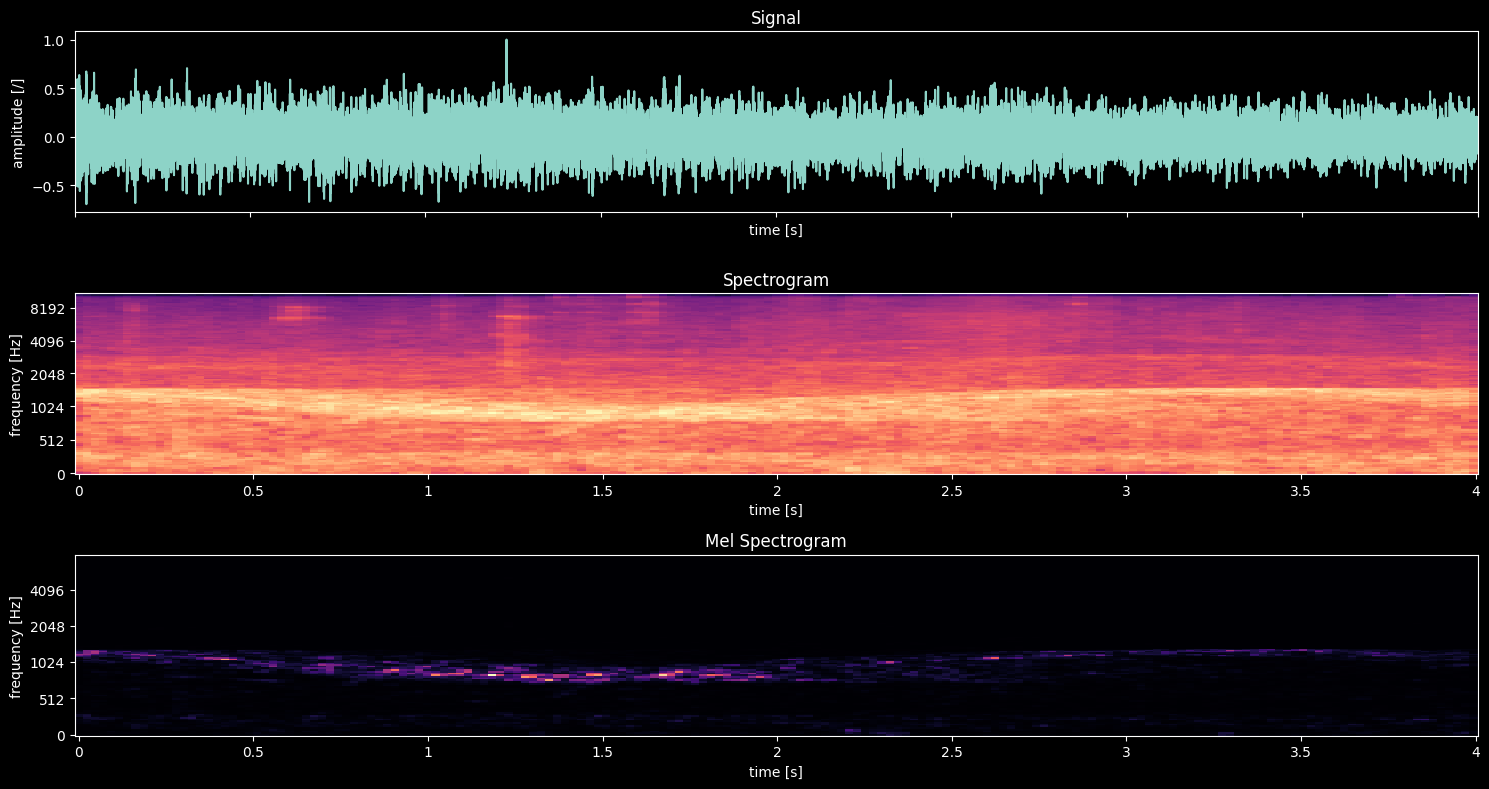

class name: siren
x[k] has 88200 samples
the sampling rate is 22.05 kHz
x(t) is 4.0s long
the number of channels is 1


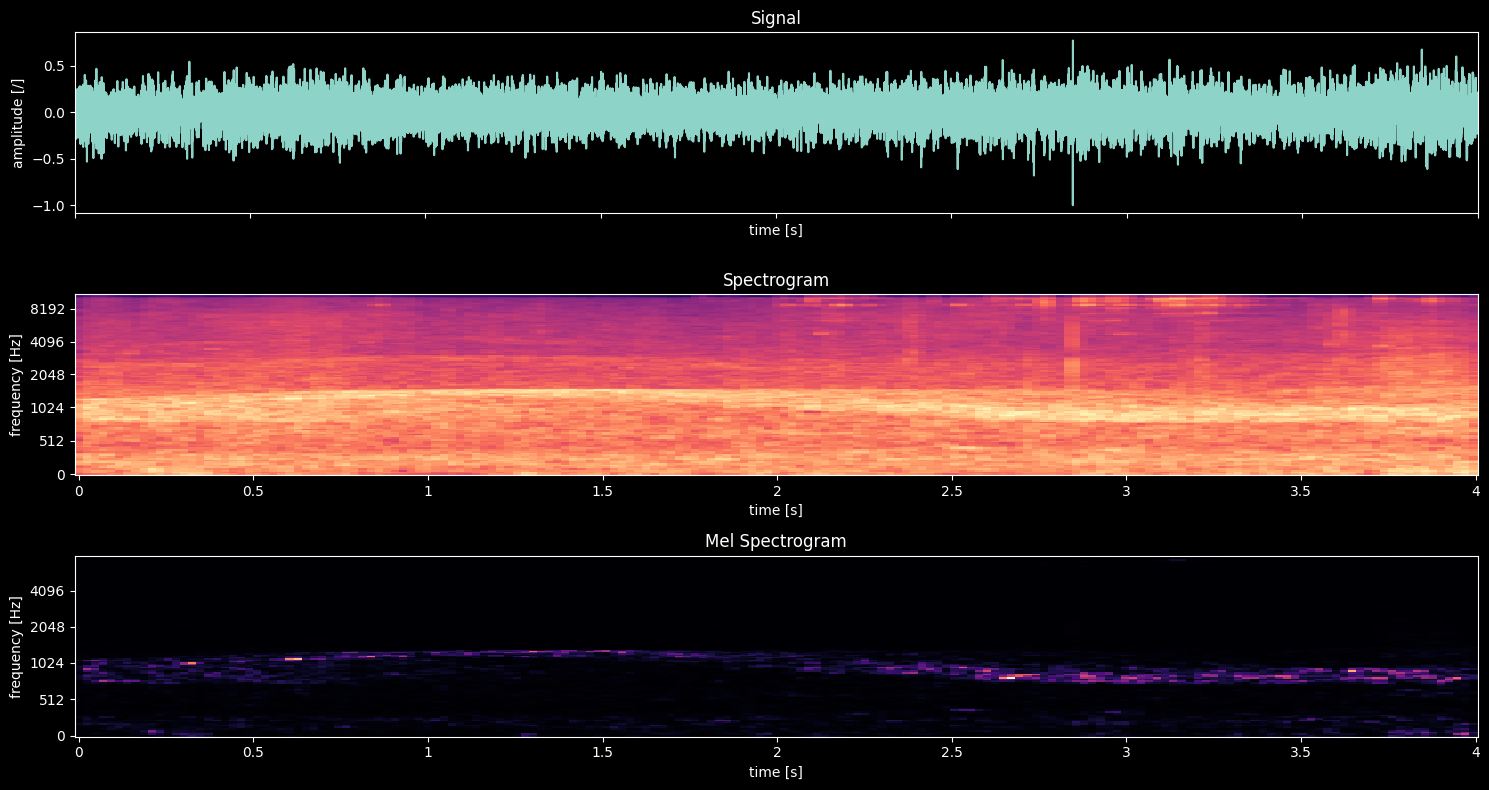

In [34]:
classes = ['siren'] # add element from the list to display more classes
nb_examples = 5 # change this number to have more examples
librosa_get_examples(metadata, nb_examples, classes)

We can create a dataframe with all mfccs of signals

In [35]:
def extract_features(filename):
    signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') # kaiser_fast: faster method
    feature = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=64)
    scaled_feature = np.mean(feature.T, axis=0) #  reduce the dimensionality of the data
    return scaled_feature

def generate_features_dataframe(df=metadata):
    extracted = []
    for index_num, row in tqdm(df.iterrows()):
        file_name = row["signal_path"]
        class_name = row['class']
        data = extract_features(file_name)
        extracted.append([data, class_name])
    features = pd.DataFrame(extracted, columns=['feature', 'class'])
    features.to_pickle(FEATURES_PATH) 
    

In [36]:
# Uncommente the following line to generate audio features dataframe 
# generate_features_dataframe()

See result of the cell above [here](./data/images/generate_features_dataframe.png)

And we can create another dataframe with melspectrogram of signals

In [82]:
def extract_melspectrogram_features(filename):
    signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') # kaiser_fast: faster method
    feature = librosa.feature.melspectrogram(y=signal, sr=sample_rate)
    return feature

def generate_melspectrogram_features_dataframe(df=metadata):
    extracted = []
    for index_num, row in tqdm(df.iterrows()):
        file_name = row["signal_path"]
        class_name = row['class']
        data = extract_melspectrogram_features(file_name)
        extracted.append([data, class_name])
    melspectrogram_features = pd.DataFrame(extracted, columns=['melspectrogram_features', 'class'])
    melspectrogram_features.to_pickle(MELSPECTROGRAM_FEATURES_PATH) 

In [83]:
# Uncommente the following line to generate audio melspectrogram features dataframe 
# generate_melspectrogram_features_dataframe()

3554it [03:09, 12.39it/s]C:\Users\grond\Documents\projects\sound_project\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [07:30, 23.67it/s]C:\Users\grond\Documents\projects\sound_project\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\grond\Documents\projects\sound_project\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [07:51, 18.53it/s]


## Deal with mffcs to create a model

In [37]:
# Load features from features.csv file
df = load_data(FEATURES_PATH, True)
df.head()

feature             class
0  [-217.35526, 70.22338, -130.38527, -53.282898,...          dog_bark
1  [-424.09818, 109.34077, -52.919525, 60.86475, ...  children_playing
2  [-458.79114, 121.38419, -46.520657, 52.00812, ...  children_playing
3  [-413.89984, 101.66373, -35.42945, 53.036354, ...  children_playing
4  [-446.60352, 113.68541, -52.402206, 60.302044,...  children_playing

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  8732 non-null   object
 1   class    8732 non-null   object
dtypes: object(2)
memory usage: 136.6+ KB


In [39]:
# Define usefull constants for model creation
EPOCHS = 1 # change here
BATCH_SIZE = 16
PATIENCE = 10
CALLBACKS=[keras.callbacks.EarlyStopping(patience=PATIENCE)]
models = []

In [40]:
# Performing label encoding on the 'class' column of the dataframe, use in all models
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(df["class"].values)

In [41]:
X = np.array(df["feature"].tolist())
X[0] # This is the form of one feature, we will modify/standardize it according to different rules in order to get the best model

array([-2.1735526e+02,  7.0223381e+01, -1.3038527e+02, -5.3282898e+01,
       -2.1199129e+01, -2.2677622e+01, -1.0855970e+01,  1.8294254e+01,
        6.6527028e+00,  1.4324025e+01, -1.2167682e+01,  2.2768366e+00,
       -1.7779188e+01,  1.0388951e+01, -6.5828357e+00, -6.9445676e-01,
       -1.8336023e+01,  1.9942534e+00, -5.1433320e+00,  8.3023996e+00,
       -1.2645056e+01, -6.5297322e+00,  4.6176677e+00, -2.1799166e+00,
       -6.6628237e+00,  3.5971048e-01, -3.9084098e+00,  4.7756243e+00,
       -6.3845210e+00, -5.3798180e+00,  9.1597855e-01,  6.9704933e+00,
       -2.4866800e-01,  1.6782187e+00, -5.6111817e+00, -2.9643466e+00,
        3.1490574e+00, -1.6930530e+00, -6.1698359e-01,  3.8600540e-01,
        1.4765122e+00,  9.1343743e-01, -3.8186760e+00, -5.3320227e+00,
       -4.7978177e+00, -5.3726900e-01, -4.9005318e+00,  3.4623352e-01,
       -4.4343567e+00,  1.3686621e+00, -5.2709943e-01, -3.3108356e+00,
       -7.7453041e-01, -3.4345752e-01, -4.1757250e+00, -3.1875610e+00,
      

## Fully connected neural network

In [42]:
X_norm2 = normalize_w_librosa(df["feature"])
X_norm2[0]

array([-0.00880367,  0.00606094, -0.03336004, -0.01912167, -0.01112449,
       -0.0117794 , -0.007447  ,  0.01218148,  0.00499736,  0.0119134 ,
       -0.01096135,  0.00210646, -0.01682001,  0.01133697, -0.00711791,
       -0.00081937, -0.02151434,  0.00268836, -0.00702806,  0.0133418 ,
       -0.01819863, -0.01145785,  0.00747807, -0.00444299, -0.01272162,
        0.00079915, -0.00844106,  0.01130977, -0.01380798, -0.01408396,
        0.00189679,  0.01909997, -0.00058214,  0.00501956, -0.01731595,
       -0.01042741,  0.01021596, -0.00426116, -0.00180036,  0.00098357,
        0.00428258,  0.00304877, -0.01453212, -0.0213233 , -0.01795376,
       -0.00214154, -0.0205873 ,  0.00136266, -0.01523781,  0.00397732,
       -0.00176664, -0.01206853, -0.00338091, -0.00164531, -0.02091637,
       -0.0151196 , -0.00581399, -0.0147009 ,  0.00100137, -0.01395171,
        0.00635142,  0.00930997, -0.00289233,  0.00886664], dtype=float32)

In [43]:
# Create all sets for fully conected model (FC)
X_train_FC, X_test_FC, X_val_FC, y_train_FC, y_test_FC, y_val_FC = generate_data(X_norm2, y)

Shape of training samples = (5238, 64)
Shape of validation samples = (1747, 64)
Shape of testing samples = (1747, 64)


In [44]:
def create_model_FC(input_shape=(64, ), num_classes=10, hidden_layers=1, units=64, activation='relu', dropout_rate=0.5, optimizer='adam'):
    # Define seed for reproducibility
    tf.random.set_seed(42)
    # Define input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Define hidden layers
    x = inputs
    for i in range(hidden_layers):
        x = keras.layers.Dense(units, activation=activation)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    
    # Define output layer
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = keras.models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [45]:
# Define hyperparameters
param_grid_FC = dict(
    hidden_layers=[2], # change here
    units=[64], # change here
    activation=['relu'],
    dropout_rate=[0.6],
    optimizer=['adam', 'sgd']
)

In [46]:
# Define model with KerasClassifier
model_FC = KerasClassifier(model=create_model_FC, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=(64, ), num_classes=10, hidden_layers=1, units=64, activation='relu', dropout_rate=0.5, optimizer='adam')

In [47]:
# define Grid Search
grid_search_FC = GridSearchCV(
    estimator=model_FC,
    param_grid=param_grid_FC,
    cv=5, 
    error_score='raise')

In [48]:
# Train model using GridSearchCV
grid_result_FC = grid_search_FC.fit(
    X_train_FC,
    y_train_FC,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_FC, y_val_FC),
    callbacks=[CALLBACKS]
)

328/328 [==============================] - 1s 2ms/step - loss: 2.2549 - accuracy: 0.1382 - val_loss: 2.1885 - val_accuracy: 0.2456


In [49]:
# Instantiate the model with the optimal hyperparameters
best_params_FC = grid_result_FC.best_params_
best_model_FC = create_model_FC(
    hidden_layers=best_params_FC['hidden_layers'],
    units=best_params_FC['units'],
    activation=best_params_FC['activation'],
    dropout_rate=best_params_FC['dropout_rate'],
    optimizer=best_params_FC['optimizer']
)

# Display the results
display_best_hyperparameters(grid_search_FC)

Best hyperparameters:
activation: relu
dropout_rate: 0.6
hidden_layers: 2
optimizer: sgd
units: 64
Best accuracy: 0.21288450461879452


In [50]:
# Training the best model
history_FC = best_model_FC.fit(
    X_train_FC,
    y_train_FC,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_FC, y_val_FC),
    callbacks=[CALLBACKS]
)

328/328 [==============================] - 1s 1ms/step - loss: 2.2866 - accuracy: 0.1264 - val_loss: 2.2752 - val_accuracy: 0.1225


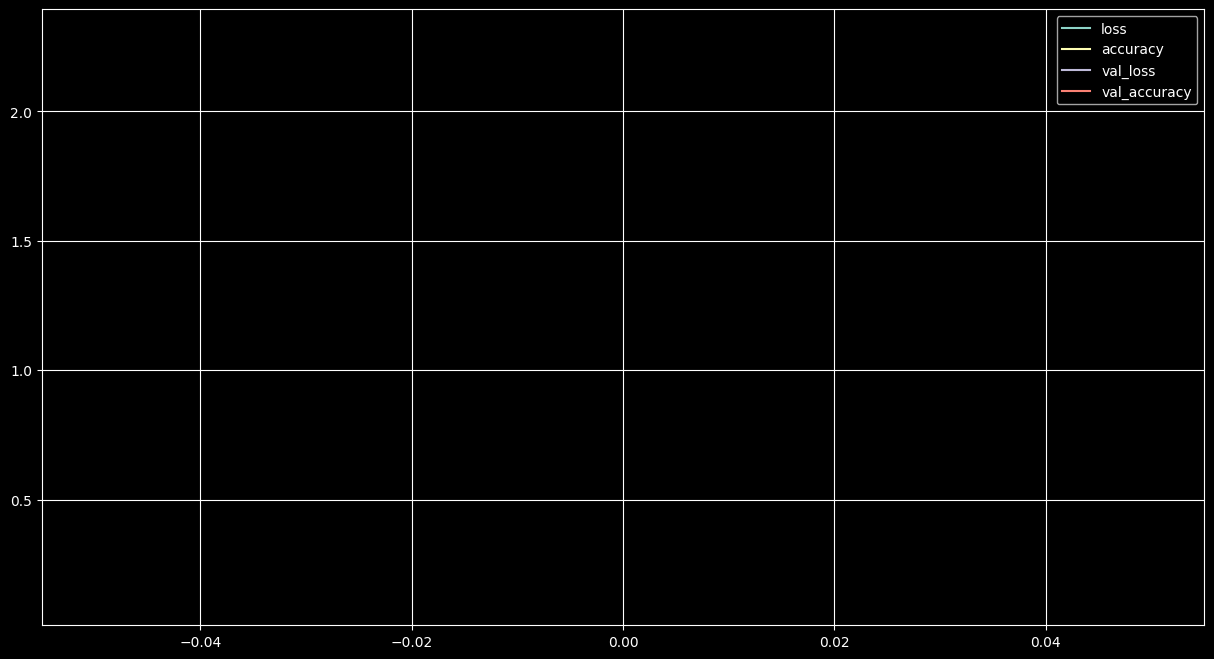

In [51]:
display_leaning_curves(history_FC)

In [52]:
# Evaluate the best model on the test data 
score_FC = evaluate_model(best_model_FC, X_test_FC, y_test_FC)

Evaluate on test data
55/55 [==============================] - 0s 749us/step - loss: 2.2742 - accuracy: 0.1122
test loss, test acc: [2.2742440700531006, 0.11219233274459839]


In [53]:
# Add FC model to models
models.append({'model': best_model_FC, 'score': score_FC})

## Convolution neural network

In [54]:
# Change shape of X to be 1 dimensional
X_CNN = np.array(df["feature"].tolist()).reshape(X.shape[0], 64, 1, 1)

In [55]:
X_train_CNN, X_test_CNN, X_val_CNN, y_train_CNN, y_test_CNN, y_val_CNN = generate_data(X_CNN, y)

Shape of training samples = (5238, 64, 1, 1)
Shape of validation samples = (1747, 64, 1, 1)
Shape of testing samples = (1747, 64, 1, 1)


In [56]:
def create_model_CNN(input_shape=(64, 1, 1), num_classes=10, num_filters=32, filter_size=3, pool_size=3, dense_units=128, activation='relu', dropout_rate=0.5, optimizer='adam'):
    model = keras.models.Sequential([
        keras.layers.Conv2D(num_filters, 
                            (filter_size, 1), 
                            activation=activation, 
                            input_shape=input_shape),
        keras.layers.MaxPooling2D((pool_size, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(dense_units, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation=activation),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    return model

In [57]:
# Define hyperparameters
param_grid_CNN = {
    'num_filters': [32],
    'filter_size': [3],
    'activation': ['relu'],
    'pool_size': [3],
    'dense_units': [128],
    'dropout_rate': [0.5],
    'optimizer': ['adam'],
}

In [58]:
# Define model with KerasClassifier
model_CNN = KerasClassifier(model=create_model_CNN, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=(64, 1, 1), num_classes=10, num_filters=32, filter_size=3, pool_size=3, dense_units=128, activation='relu', dropout_rate=0.5, optimizer='adam')

In [59]:
# define Grid Search
grid_search_CNN = GridSearchCV(
    estimator=model_CNN,
    param_grid=param_grid_CNN,
    cv=5, 
    error_score='raise')

In [60]:
# Train model using GridSearchCV
grid_result_CNN = grid_search_CNN.fit(
    X_train_CNN,
    y_train_CNN,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_CNN, y_val_CNN),
    callbacks=[CALLBACKS]
)

328/328 [==============================] - 1s 2ms/step - loss: 2.4142 - accuracy: 0.3058 - val_loss: 1.4702 - val_accuracy: 0.5180


In [61]:
# Instantiate the model with the optimal hyperparameters
best_params_CNN = grid_result_CNN.best_params_
best_model_CNN = create_model_CNN(
    activation=best_params_CNN['activation'],
    dense_units=best_params_CNN['dense_units'],
    dropout_rate=best_params_CNN['dropout_rate'],
    filter_size=best_params_CNN['filter_size'],
    num_filters=best_params_CNN['num_filters'],
    optimizer=best_params_CNN['optimizer'],
    pool_size=best_params_CNN['pool_size']
)

# Display the results
display_best_hyperparameters(grid_search_CNN)

Best hyperparameters:
activation: relu
dense_units: 128
dropout_rate: 0.5
filter_size: 3
num_filters: 32
optimizer: adam
pool_size: 3
Best accuracy: 0.48224097202475996


In [62]:
# Training the best model
history_CNN = best_model_CNN.fit(
    X_train_CNN,
    y_train_CNN,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_CNN, y_val_CNN),
    callbacks=[CALLBACKS]
)

328/328 [==============================] - 1s 2ms/step - loss: 2.2030 - accuracy: 0.3068 - val_loss: 1.4434 - val_accuracy: 0.5215


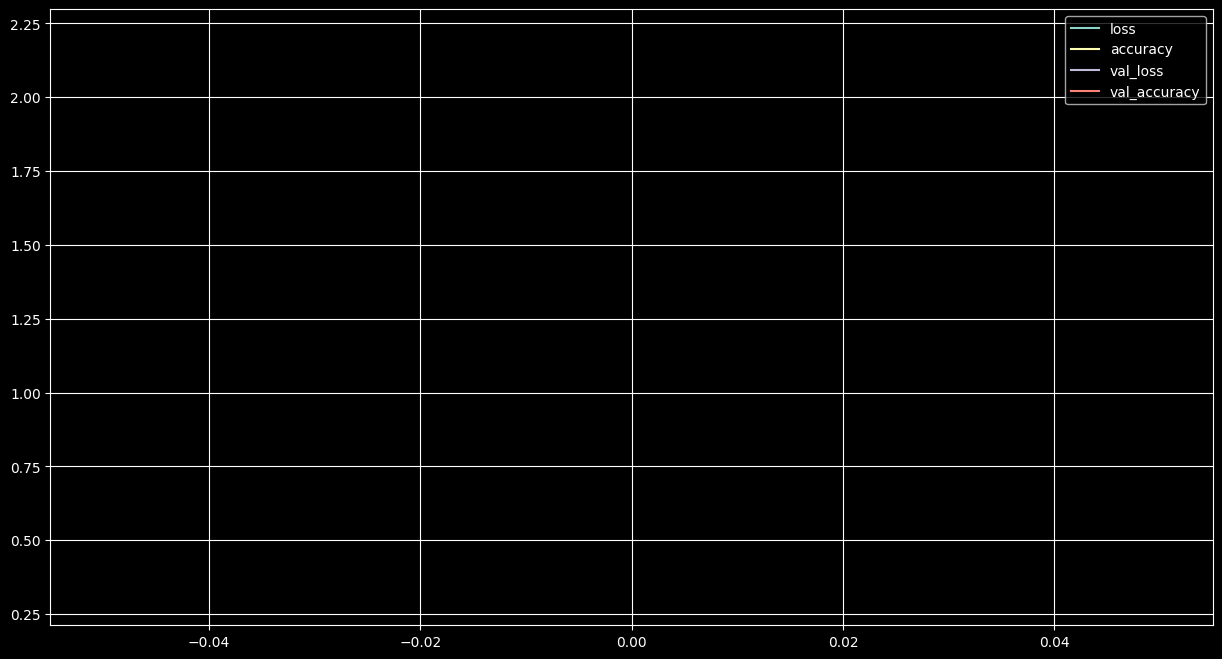

In [63]:
display_leaning_curves(history_CNN)

In [64]:
# Evaluate the best model on the test data 
score_CNN = evaluate_model(best_model_CNN, X_test_CNN, y_test_CNN)

Evaluate on test data
55/55 [==============================] - 0s 1ms/step - loss: 1.3996 - accuracy: 0.5581
test loss, test acc: [1.3996076583862305, 0.558099627494812]


In [65]:
models.append({'model': best_model_CNN, 'score': score_CNN})

## Save best model

In [66]:
best_model = max(models, key=lambda x: x['score'])
best_model

{'model': <keras.engine.sequential.Sequential at 0x255269b3130>,
 'score': 0.558099627494812}

In [67]:
best_model['model'].save(BEST_MODEL_PATH)

INFO:tensorflow:Assets written to: sound_project_model\assets


INFO:tensorflow:Assets written to: sound_project_model\assets


In [68]:
loaded_model = keras.models.load_model(BEST_MODEL_PATH)
loaded_model

# Conclusion and go further